# Случайный лес

Использование Bagging или RSM для Log-Reg или подобных моделей не несет большого смысла. Но для деревьев решений это не так. Будем брать деревья большой глубины. Незначительные изменения в данных приводят к значительным  изменениям в топологии таких деревьев. Таким образом, мы приходим к **случайному лесу** = Bagging + RSM над деревом решений.

При этом RSM в классическом случайном лесе делается не на уровне дерева, а на уровне узла. В каждом узле дерева, когда мы выбираем лучшее разбиение его на два дочерних, мы просматриваем не все признаки, а только определенное их количество.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/random_forest.png" width="900"/></center>

Случайный лес работает лучше, чем отдельное случайно взятое дерево. Но главное, что случайный лес намного более устойчив к шуму.
Это свойство до сих пор позволяет случайному лесу успешно использоваться в областях с шумными данными.

## Зависимость качества случайного леса от числа деревьев
Для случайного леса верно следующее: когда мы берем множество базовых классификаторов (в данном случае деревьев) и усредняем их, то **результат этих усреднений стремится к идеальному дереву решений**, причем построенному на идеальных, а не на исходных признаках.

Проверим это на задаче регрессии [California Housing dataset 🛠️[doc]](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

In [1]:
import sklearn
from sklearn import datasets
import pandas as pd

calif_housing = sklearn.datasets.fetch_california_housing(as_frame=True)

pd.concat([calif_housing["data"], calif_housing["target"]], axis=1).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Данные — средние характеристики квартиры в доме. Цель — предсказать цену на дом.

In [2]:
from sklearn.model_selection import train_test_split

x = calif_housing["data"].values
y = calif_housing["target"].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

models_rf = {}

# add single decision tree for comparison
models_rf["DT"] = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10)

# this can be done faster, see warm_start parameter for this
# (https://stackoverflow.com/questions/42757892/how-to-use-warm-start)
for n_estimators in [3, 5, 10, 50, 100, 150, 250]:
    models_rf[f"RF{n_estimators}"] = RandomForestRegressor(
        n_estimators=n_estimators, random_state=42, n_jobs=-1
    )

Создадим несколько случайных лесов с различным количеством деревьев и простое дерево решений для сравнения с ним (baseline).

Обучим все модели.
Для этого напишем вспомогательную функцию, которая будет обучать переданные ей модели и считать для них качество на тесте.

In [4]:
from sklearn.utils import resample
import numpy as np

def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)

    for sample in range(samples_cnt):
        x_boot, y_boot = resample(x, y, replace=True, n_samples=x.shape[0])
        b_metric[sample] = metric_fn(x_boot, y_boot)

    return b_metric

In [5]:
from sklearn.metrics import mean_squared_error


def train_and_test_regressor(models, x_train, y_train, x_test, y_test, verb=True):
    boot_scores = {}
    for name, model in models.items():
        model.fit(x_train, y_train)  # train the model
        y_pred = model.predict(x_test)  # get predictions
        boot_scores[name] = bootstrap_metric(  # calculate bootstrap score
            y_test,
            y_pred,
            metric_fn=mean_squared_error,
        )
        if verb:
            print(f"Fitted {name} with bootstrap score {boot_scores[name].mean():.3f}")

    results = pd.DataFrame(boot_scores)

    return results


results_rf = train_and_test_regressor(models_rf, x_train, y_train, x_test, y_test)

Fitted DT with bootstrap score 0.395
Fitted RF3 with bootstrap score 0.338
Fitted RF5 with bootstrap score 0.302
Fitted RF10 with bootstrap score 0.277
Fitted RF50 with bootstrap score 0.257
Fitted RF100 with bootstrap score 0.254
Fitted RF150 with bootstrap score 0.252
Fitted RF250 with bootstrap score 0.252


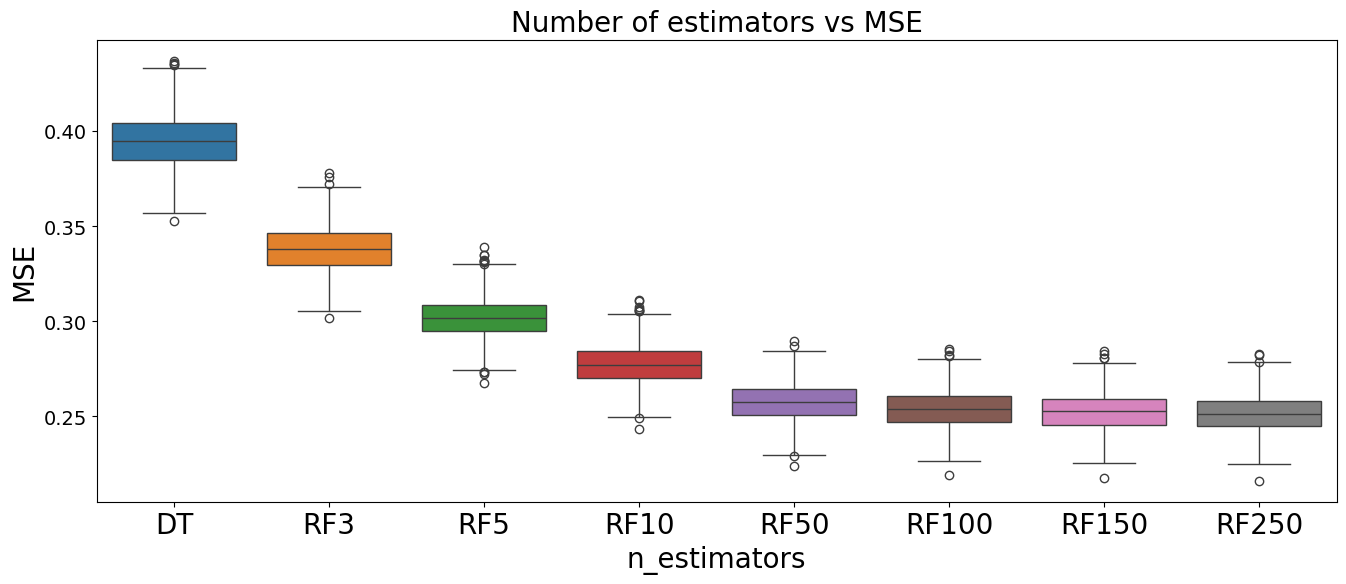

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.boxplot(data=results_rf)
plt.ylabel("MSE", size=20)
plt.xlabel("n_estimators", size=20)
plt.title("Number of estimators vs MSE", size=20)
plt.tick_params(axis="both", which="major", labelsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=14)
plt.show()

Увеличение числа базовых моделей сначала сильно улучшает качество модели. Однако после определенного количества базовых моделей улучшение качества становится незначительным.

## Зависимость качества случайного леса от глубины дерева

Чем больше глубина дерева, тем большая нескоррелированность базовых моделей будет получаться. В общем случае в случайном лесе важно использовать именно глубокие деревья, причем в большинстве случаев их глубину не надо ограничивать (или ограничивать большими значениями порядка 10–12).

Обучим случайный лес с заданной глубиной дерева и сравним с одиночным деревом такой же глубины.

In [7]:
dt_depth = {}
rf_depth = {}

for depth in range(1, 20, 2):
    dt_depth[depth] = DecisionTreeRegressor(max_depth=depth, random_state=42)

    rf_depth[depth] = RandomForestRegressor(
        n_estimators=100, max_depth=depth, random_state=42, n_jobs=-1
    )  # run in parallel

dt_res = train_and_test_regressor(
    dt_depth, x_train, y_train, x_test, y_test, verb=False
)
rf_res = train_and_test_regressor(
    rf_depth, x_train, y_train, x_test, y_test, verb=False
)

dt_res = dt_res.melt(value_vars=dt_res.columns, value_name="mse", var_name="tree_depth")
dt_res["model"] = "DT"
rf_res = rf_res.melt(value_vars=rf_res.columns, value_name="mse", var_name="tree_depth")
rf_res["model"] = "RF"
depth_res = pd.concat((dt_res, rf_res))

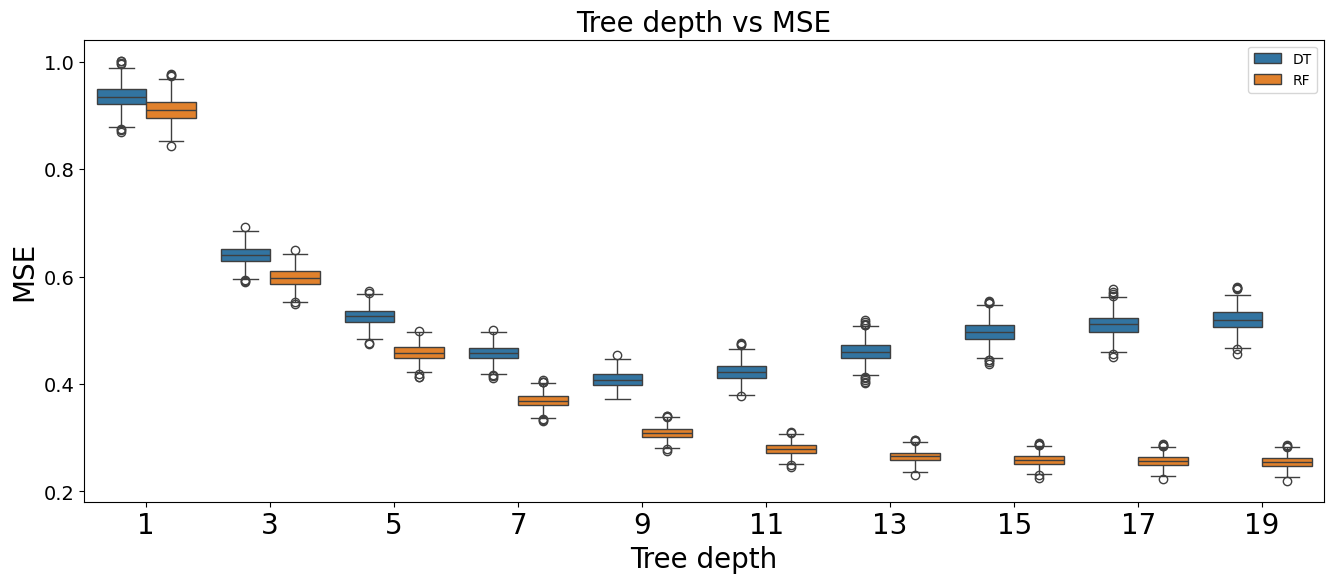

In [8]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=depth_res, x="tree_depth", y="mse", hue="model")
plt.xlabel("Tree depth", size=20)
plt.ylabel("MSE", size=20)
plt.title("Tree depth vs MSE", size=20)
plt.legend()
plt.tick_params(axis="both", which="major", labelsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=14)
plt.show()

Лучшие результаты показывает случайный лес из наиболее глубоких деревьев.

Качество случайного леса с малой глубиной дерева не отличается от качества одиночного дерева той же глубины. Это связано с тем, что деревья малой глубины слабо отличаются друг от друга (высокий bias и низкий variance), потому усреднение их предсказаний почти не улучшает качество.

Отметим, что в случае малых выборок ограничения на глубину дерева могут дать выигрыш.

## Минимальное число объектов в листе
Иногда качество случайного леса можно улучшить, если поставить небольшое ограничение на минимальное число объектов в листе, чтобы запретить явно переобученные деревья.

In [9]:
dt_models_min_samples = {}
rf_models_min_samples = {}

for mn_sm in [1, 3, 5, 7, 10]:
    dt_models_min_samples[mn_sm] = DecisionTreeRegressor(
        max_depth=None, min_samples_leaf=mn_sm, random_state=42
    )

    rf_models_min_samples[mn_sm] = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=mn_sm,
        random_state=42,
        n_jobs=-1,
    )  # run in parallel

dt_results_mn_samples = train_and_test_regressor(
    dt_models_min_samples, x_train, y_train, x_test, y_test
)
rf_results_mn_samples = train_and_test_regressor(
    rf_models_min_samples, x_train, y_train, x_test, y_test
)

dt_results_mn_samples = dt_results_mn_samples.melt(
    value_vars=dt_results_mn_samples.columns, value_name="mse", var_name="min_samples"
)
dt_results_mn_samples["model"] = "DT"
rf_results_mn_samples = rf_results_mn_samples.melt(
    value_vars=rf_results_mn_samples.columns, value_name="mse", var_name="min_samples"
)
rf_results_mn_samples["model"] = "RF"
leaf_res = pd.concat((dt_results_mn_samples, rf_results_mn_samples))

Fitted 1 with bootstrap score 0.528
Fitted 3 with bootstrap score 0.446
Fitted 5 with bootstrap score 0.428
Fitted 7 with bootstrap score 0.405
Fitted 10 with bootstrap score 0.388
Fitted 1 with bootstrap score 0.254
Fitted 3 with bootstrap score 0.256
Fitted 5 with bootstrap score 0.260
Fitted 7 with bootstrap score 0.266
Fitted 10 with bootstrap score 0.274


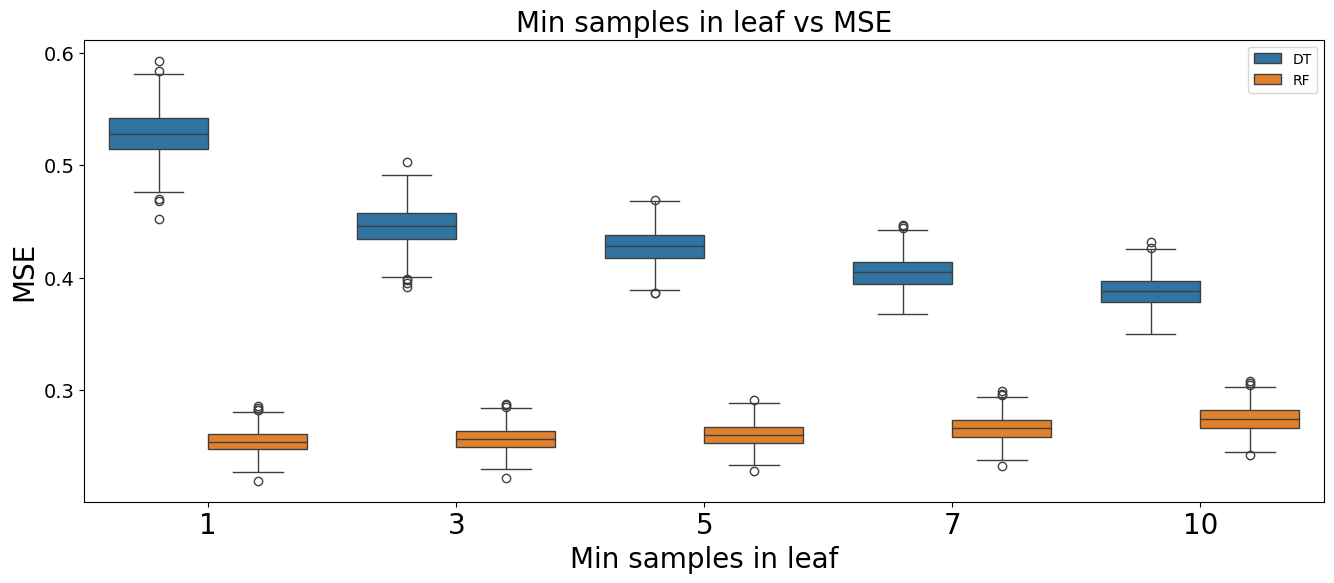

In [10]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=leaf_res, x="min_samples", y="mse", hue="model")
plt.xlabel("Min samples in leaf", size=20)
plt.ylabel("MSE", size=20)
plt.title("Min samples in leaf vs MSE", size=20)
plt.tick_params(axis="both", which="major", labelsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=20)
plt.legend()
plt.show()

В данном случае, однако, ограничение на количество объектов в листе ухудшает качество ансамбля. Одна из причин заключается в том, что с увеличением числа ограничений на дерево уменьшается непохожесть деревьев друг на друга, и качество случайного леса так же начинает уменьшаться.

## Про другие реализации случайного леса

В библиотеках XGBoost и LightGBM есть свои, более быстрые и иногда более эффективные реализации случайного леса. Но их надо дополнительно настраивать.

In [11]:
!pip install -q dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 4.3 MB/s eta 0:00:00


In [12]:
import xgboost
import lightgbm

models_rf = {}

models_rf["SL_RF"] = RandomForestRegressor(
        n_estimators=250, max_depth=depth, random_state=42, n_jobs=-1)

models_rf["XGB_RF"] = xgboost.XGBRFRegressor(
    n_estimators=250,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_lambda=0.001,  # to get deeper, less regularized trees
    max_depth=20,  # trees must be deep
    n_jobs=-1,
    objective="reg:squarederror",
)

models_rf["LGBM_RF"] = lightgbm.LGBMRegressor(
    n_estimators=250,
    subsample_freq=1,  # for lgb random forest must be set to 1
    num_leaves=2**14,  # don't forget to change the number of leaves to smth big
    boosting_type="rf",  # set boosteer type
    colsample_bytree=0.8,  # for lgb random forest must be less then 1
    subsample=0.8,  # for lgb random forest must be less then 1
    min_child_samples=1,  # to get deeper trees
    n_jobs=-1,
    force_col_wise=True,
    verbose=-1,
)

rf_add = train_and_test_regressor(models_rf, x_train, y_train, x_test, y_test)

Fitted SL_RF with bootstrap score 0.252
Fitted XGB_RF with bootstrap score 0.235
Fitted LGBM_RF with bootstrap score 0.236


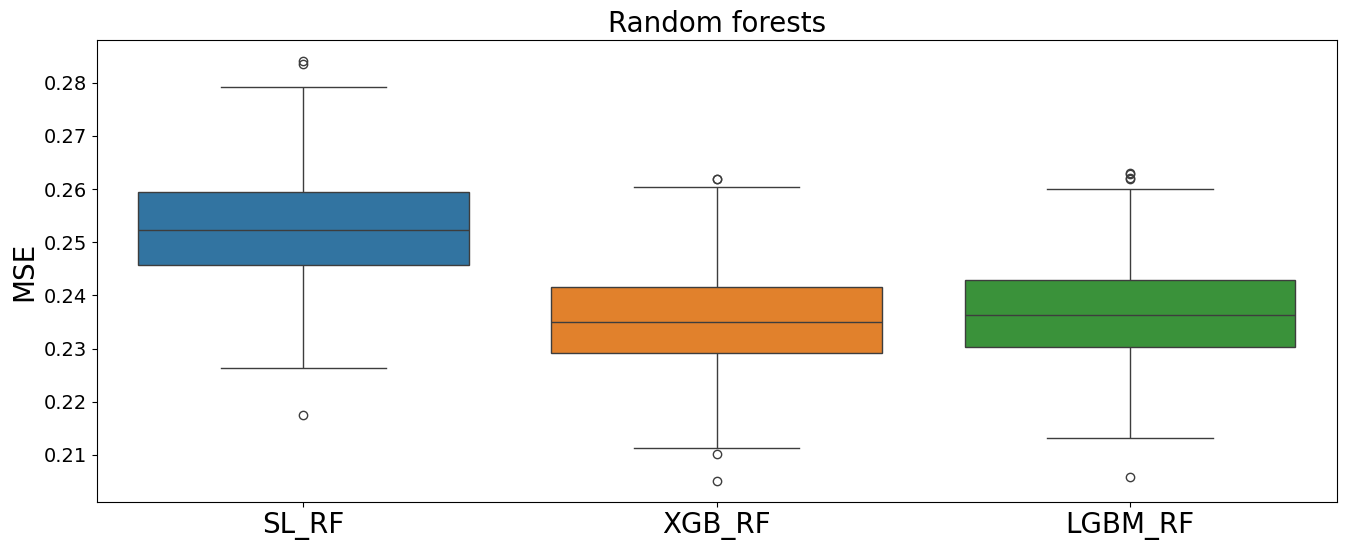

In [13]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=pd.concat([rf_add]))

plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Random forests", size=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=20)
plt.show()

Заметьте, что в данном случае они показывают себя иначе, нежели `sklearn.RandomForest`. Это частое явление, так как деревья в пакетах XGBoost и LightGBM строятся отличным от sklearn образом. Это может как улучшать качество, так и ухудшать.

## Переобучение случайного леса

Существует мнение, что случайный лес не переобучается. Это не так. Можно подобрать такие два набора параметров, что первый даст лучшее качество на тренировочной выборке, а второй — на тестовой. При этом увеличение числа деревьев в ансамбле с этим справиться поможет слабо.

Возьмем, к примеру, наш синтетический пример на плоскости.

In [14]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(
    clf, x, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.85, contour=True, bolded=False
):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    x_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(x_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#FEE7D0", "#bea6ff", "#B8E1EC"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#FEE7D0", "#5D5DA6", "#B8E1EC"])
        if bolded:
            custom_cmap2 = ListedColormap(["#FEE7D0", "#5D5DA6", "#000000"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2)
    plt.plot(x[:, 0][y == 0], x[:, 1][y == 0], "D", c="#F9B041", alpha=alpha)
    plt.plot(x[:, 0][y == 1], x[:, 1][y == 1], "o", c="#2DA9E1", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

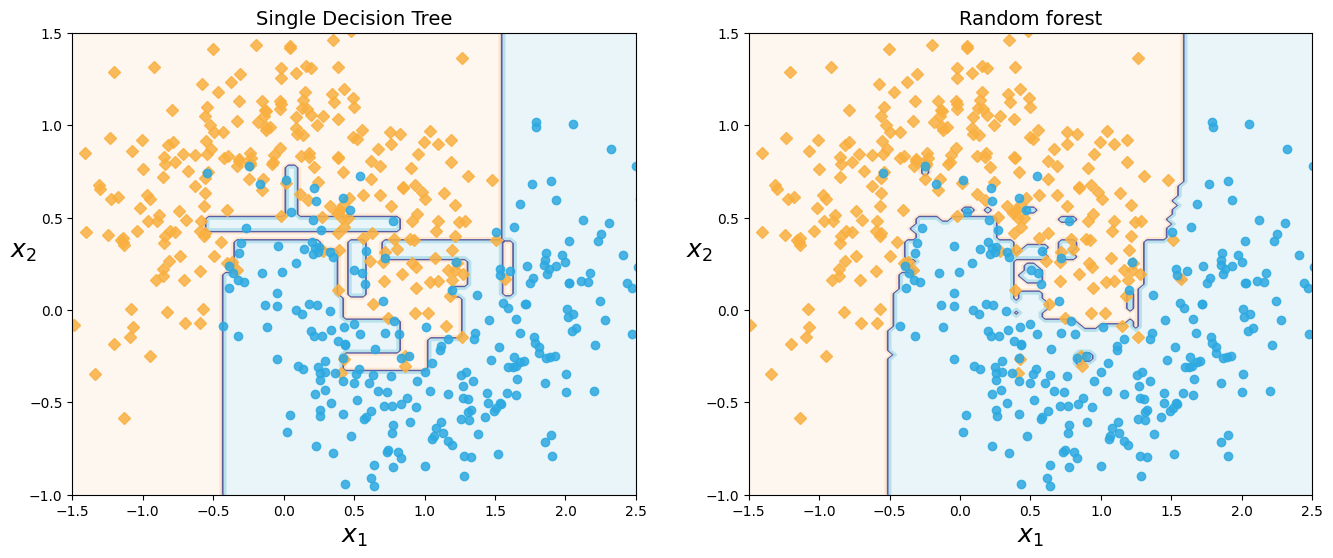

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

x, y = sklearn.datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
plt.figure(figsize=(16, 6))
plt.subplot(121)

clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(x_train, y_train)
plot_decision_boundary(clf, x, y)
plt.title("Single Decision Tree", fontsize=14)

plt.subplot(122)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)
plot_decision_boundary(rf, x, y)
plt.title("Random forest", fontsize=14)
plt.show()

Видны области, в которых случайный лес переобучился.

Добавление ограничения на число объектов в листьях улучшает ситуацию.

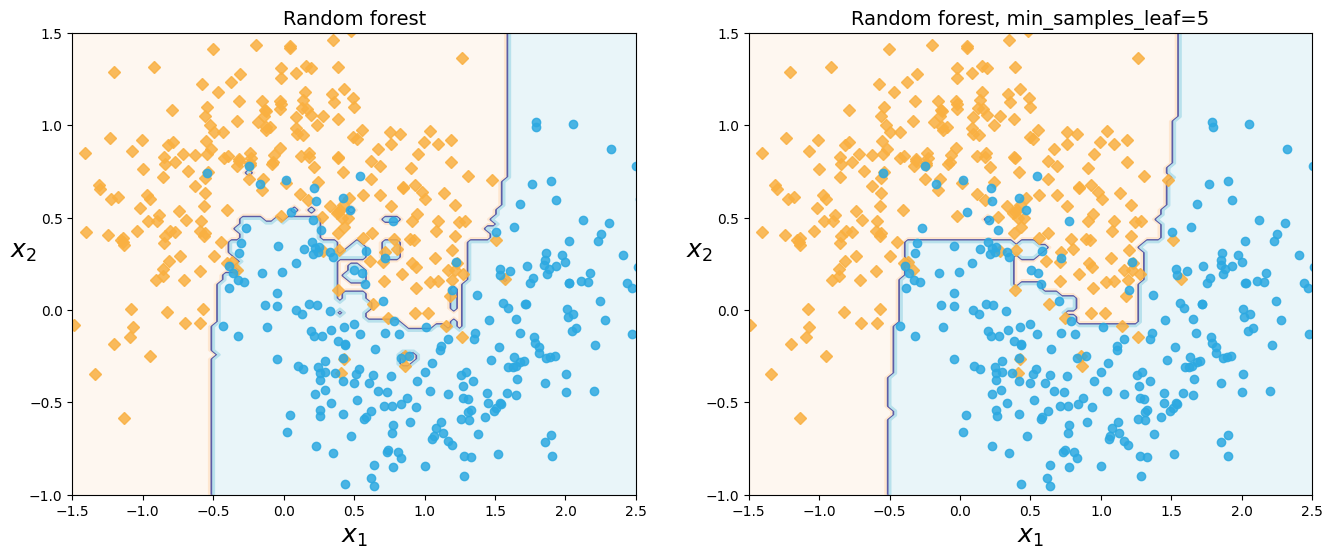

In [17]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
rf1 = RandomForestClassifier(n_estimators=1000)
rf1.fit(x_train, y_train)
plot_decision_boundary(rf1, x, y)
plt.title("Random forest", fontsize=14)

plt.subplot(122)
rf2 = RandomForestClassifier(n_estimators=1000, min_samples_leaf=5)
rf2.fit(x_train, y_train)
plot_decision_boundary(rf2, x, y)
plt.title("Random forest, min_samples_leaf=5", fontsize=14)
plt.show()

Лес без ограничения на минимальное число объектов в листе переобучился — достиг максимального качества на обучающей выборке, но на тестовой имеет качество ниже, чем лес с ограничением.

In [18]:
from sklearn.metrics import average_precision_score

y_score = rf1.predict(x_train)
q = average_precision_score(y_true=y_train, y_score=y_score)
print(f"RF1 Train: {q:.02}")
y_score = rf1.predict(x_test)
q = average_precision_score(y_true=y_test, y_score=y_score)
print(f"RF1 Test: {q:.02}")

y_score = rf2.predict(x_train)
q = average_precision_score(y_true=y_train, y_score=y_score)
print(f"RF2 Train: {q:.02}")
y_score = rf2.predict(x_test)
q = average_precision_score(y_true=y_test, y_score=y_score)
print(f"RF2 Test: {q:.02}")

RF1 Train: 1.0
RF1 Test: 0.87
RF2 Train: 0.91
RF2 Test: 0.91


## Валидация случайного леса на Out-Of-Bag (OOB) объектах

Благодаря механизму обучения случайного леса у нас появляется еще один способ валидировать модель. Для обучения каждого дерева используются не все объекты нашей выборки, следовательно, мы можем получать предсказания деревьев на объектах, которые не использовались для обучения этих деревьев.



<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L03/out/oob_rf.png" width="800"></center>

За это отвечает параметр `oob_score` (по умолчанию `False`)

In [19]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf_oob = RandomForestClassifier(n_estimators=1000, min_samples_leaf=5, oob_score=True)
rf_oob.fit(x, y)
print(f"RF OOB score: {rf_oob.oob_score_:.02}")

scores = cross_validate(rf_oob, x, y, cv=5)
print(f"RF CV score: {scores['test_score'].mean():.02}")

rf_oob.fit(x_train, y_train)
print(f"RF Test set score: {rf_oob.score(x_test, y_test):.02}")

RF OOB score: 0.92
RF CV score: 0.91
RF Test set score: 0.92


Важно понимать, что OOB score не заменяет другие способы валидации, а является дополнительным способом, который используется в основном тогда, когда данных мало.